In [8]:
import numpy as np
import xarray as xr
import glob
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [80]:
# monthly density files 
files = glob.glob('/Users/jakesteinberg/Documents/CPT/Argo/MIMOC/MIMOC_Z*.nc')
files = np.sort(files)
argo = xr.open_dataset(files[0],decode_times=False)

In [64]:
# pressure index to output for gradient calculation 
p_i = 2 # 10 meters 
p = argo['PRESSURE'].data[p_i]
lat = argo['LATITUDE'].data
lon = argo['LONGITUDE'].data

In [66]:
density = np.nan*np.ones((12, len(argo['LATITUDE']), len(argo['LONGITUDE'])))
for m in range(12):
    argo = xr.open_dataset(files[m],decode_times=False)
    density[m] = gsw.sigma0(argo['ABSOLUTE_SALINITY'].data[p_i], argo['CONSERVATIVE_TEMPERATURE'].data[p_i])    

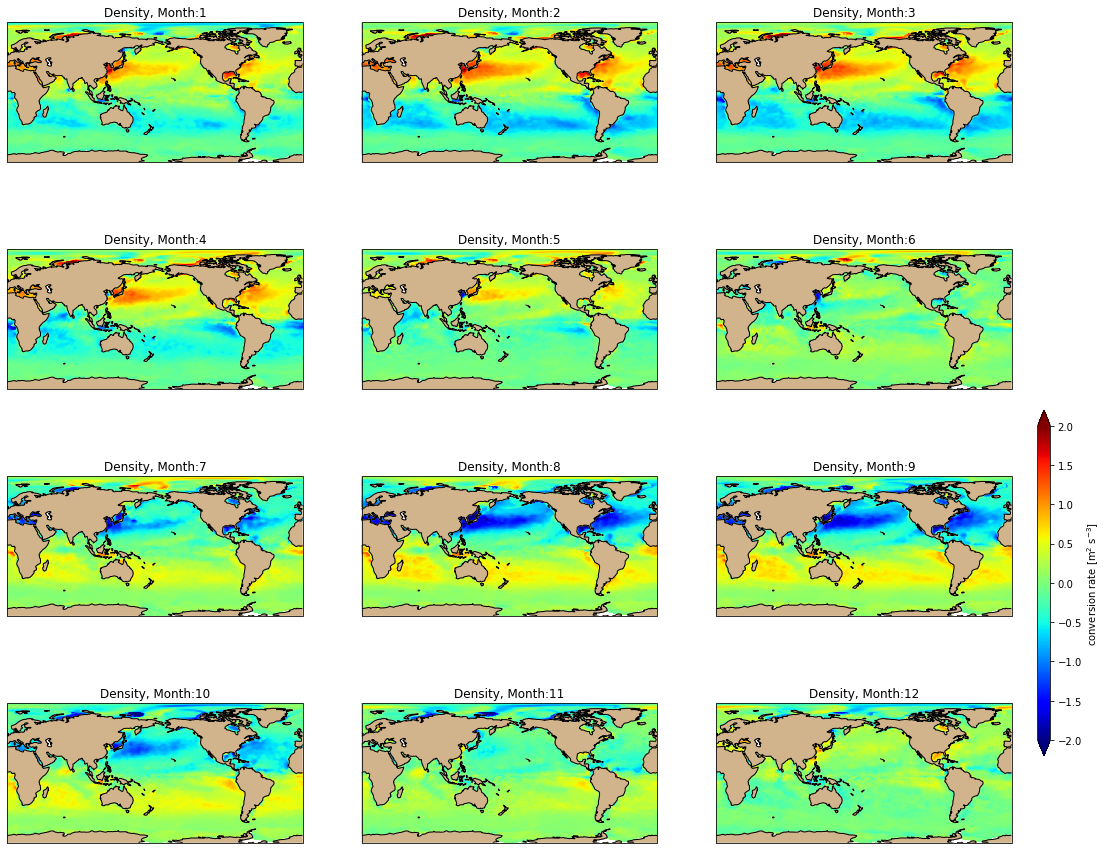

In [70]:
data_coords = {'latitude': lat, 'longitude': lon}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(4,3,figsize=(18,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    # grad_test = gradx[i,:,:]**2 + grady[i,:,:]**2
    arg_d = xr.DataArray(data=density[i] - np.nanmean(density,axis=0), \
                         dims=['latitude', 'longitude'], coords=data_coords) # ape_rate[i,:,:]
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=-2, vmax=2, \
                     cmap=tcmap_2, zorder=0, add_colorbar=False) # norm=LogNorm(vmin=0.000001, vmax=0.005)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('Density, Month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p,cax=cax,orientation='vertical',extend='both',label='conversion rate [m$^2$ s$^{-3}$]')
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/pe_conversions/pe_conversion_rate_2Deg_w_sf.jpg', dpi=250)

In [86]:
# monthly mld files 
mfiles = glob.glob('/Users/jakesteinberg/Documents/CPT/Argo/MIMOC/MIMOC_ML_v2/MIMOC_ML*.nc')
mfiles = np.sort(mfiles)
margo = xr.open_dataset(mfiles[0],decode_times=False)

In [87]:
li = np.where((margo['LATITUDE'].data >= np.nanmin(lat)) & \
         (margo['LATITUDE'].data <= np.nanmax(lat)))[0]

In [90]:
mld = np.nan*np.ones((12, len(lat), len(margo['LONGITUDE'])))
for m in range(12):
    margo = xr.open_dataset(mfiles[m],decode_times=False)
    mld0 = margo['DEPTH_MIXED_LAYER'].data
    mld[m] = mld0[li,:]

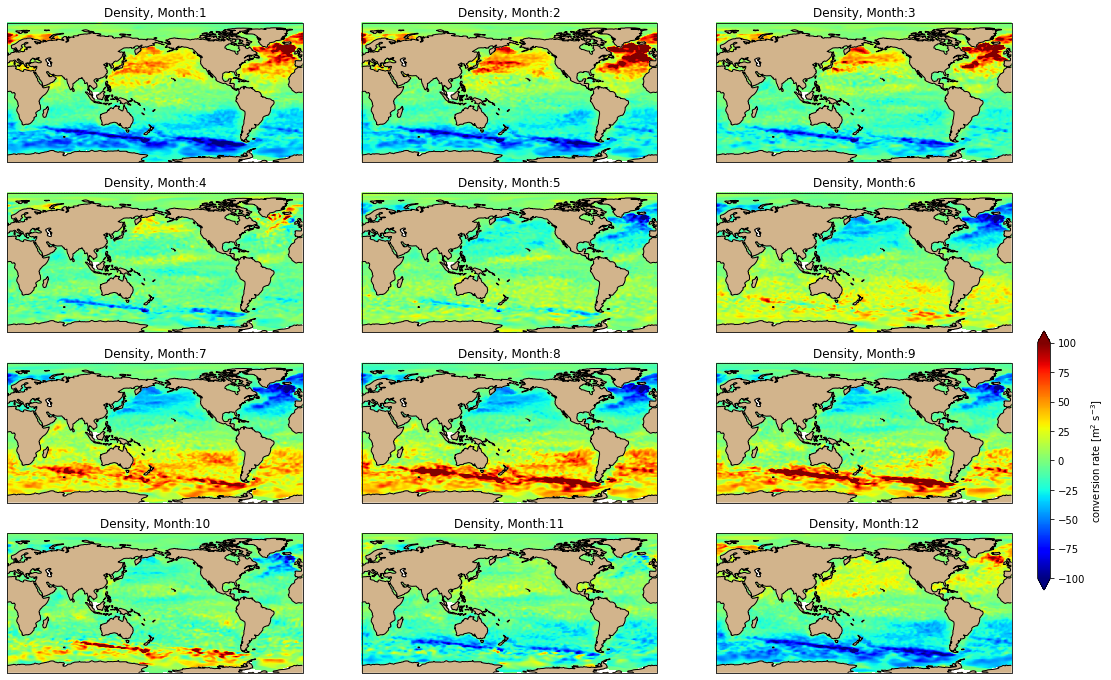

In [91]:
clims = [1e-6, 5e-5] # [1e-10, 1e-7] # old gradient [2e-16, 2e-12]
data_coords = {'latitude': lat, 'longitude': lon}
tcmap_2 = plt.get_cmap('jet')
f, ax = plt.subplots(4,3,figsize=(18,12), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    # grad_test = gradx[i,:,:]**2 + grady[i,:,:]**2
    arg_d = xr.DataArray(data=mld[i] - np.nanmean(mld,axis=0), \
                         dims=['latitude', 'longitude'], coords=data_coords) # ape_rate[i,:,:]
    arg_d_p = arg_d.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=-100, vmax=100, \
                     cmap=tcmap_2, zorder=0, add_colorbar=False) # norm=LogNorm(vmin=0.000001, vmax=0.005)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gax[i].set_title('Density, Month:' + str(i+1))
cbpos = [0.92, 0.222, 0.01, 0.3]
cax = f.add_axes(cbpos)
cb = f.colorbar(arg_d_p,cax=cax,orientation='vertical',extend='both',label='conversion rate [m$^2$ s$^{-3}$]')
# f.savefig('/Users/jakesteinberg/Desktop/cpt_manuscript_figures/r2/pe_conversions/pe_conversion_rate_2Deg_w_sf.jpg', dpi=250)

In [94]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/mimoc_potential_density_10m_w_mld.nc')
ds = xr.Dataset(
    data_vars=dict(
        density=(["month","lat","lon"], density),
        mld=(["month","lat","lon"], mld),
    ),
    coords=dict(
        month=(["month"], np.arange(0,12,1)),
        latitude=(["lat"], lat),
        longitude=(["lon"], lon),
    ),
)
ds.to_netcdf(path=filename)